# DDBot Chat Efficient Batch Evaluation

This notebook implements efficient batch evaluation for the DDBot Chat system using the `run_single_task` function. The system has been updated to:

1. Use `run_single_task` directly for consistent evaluation that matches actual system behavior
2. Properly handle human intervention scenarios by evaluating based on candidates
3. Provide accurate metrics that reflect the system's true performance
4. Remove the complexity of cached evaluation in favor of direct task execution

This approach ensures evaluation results accurately represent the system's actual behavior in production.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Setup and Configuration
import sys
import json
import logging
import subprocess
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Any
import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

# Add project root to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Configure visualization
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Base paths
BASE_DIR = project_root
DATA_DIR = BASE_DIR / "data_store" / "test_data"
CACHE_DIR = DATA_DIR / "recognition_cache"
RESULTS_DIR = DATA_DIR / "Annotated data" / "evaluation_results"
LOGS_DIR = DATA_DIR / "Annotated data"

# Ensure directories exist
CACHE_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {project_root}")
print(f"Cache directory: {CACHE_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Python path: {sys.executable}")

# Test CLI availability
try:
    result = subprocess.run([
        sys.executable, "-m", "server.measure_system_metrics", "--help"
    ], cwd=project_root, capture_output=True, text=True, timeout=30)
    if result.returncode == 0:
        print("✓ CLI module accessible")
    else:
        print(f"⚠ CLI module error: {result.stderr}")
except Exception as e:
    print(f"⚠ CLI test failed: {e}")

Project root: c:\Users\qwert\Documents\Git\ddbot-chat
Cache directory: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache
Results directory: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results
Python path: c:\Users\qwert\AppData\Local\Programs\Python\Python313\python.exe
✓ CLI module accessible


## 1. Generate Recognition Cache Files

Recognition is the expensive part of the evaluation process (requires many LLM calls). We'll generate different recognition caches that can be reused across multiple validation experiments.

In [3]:
def generate_recognition_with_settings(
    experiment_name: str,
    candidates_config: Dict[str, int],
    pool_size: int = 6,
    advance_ratio: float = 0.33,
    recognition_rounds: int = 1,
    sample_size: int = 50,
    model: str = "gpt-4o-mini",
    threshold: float = 0.5,
    validation_rounds: int = 1,
    chain_of_thought: bool = False,
    distill_knowledge: bool = False,
    sample_non_none_only: bool = False,
    approach: str = "proba"
) -> str:
    """
    Run evaluation with specific settings using run_single_task directly.
    
    Args:
        experiment_name: Name for the experiment
        candidates_config: Number of candidates per class
        pool_size: Tournament pool size
        advance_ratio: Tournament advance ratio
        recognition_rounds: Number of recognition rounds
        sample_size: Number of samples to process
        model: LLM model to use
        threshold: Validation threshold
        validation_rounds: Number of validation rounds
        chain_of_thought: Whether to use Chain of Thought
        distill_knowledge: Whether to distill knowledge
        sample_non_none_only: Whether to sample only non-None results

    Returns:
        Path to generated results file
    """

    cache_file = CACHE_DIR / f"{experiment_name}.json"
    
    print(f"Running evaluation: {experiment_name}")
    print(f"  - Candidates: {candidates_config}")
    print(f"  - Pool size: {pool_size}, Advance ratio: {advance_ratio}")
    print(f"  - Recognition rounds: {recognition_rounds}")
    print(f"  - Validation: threshold={threshold}, rounds={validation_rounds}")
    print(f"  - Sample size: {sample_size}")
    
    # Build CLI command
    cmd = [
        sys.executable, "-m", "server.measure_system_metrics",
        "--sample_size", str(sample_size),
        "--number_of_candidates", json.dumps(candidates_config),
        "--rounds", json.dumps({"recognition": recognition_rounds, "validation": validation_rounds}),
        "--pool_size", str(pool_size),
        "--advance_ratio", str(advance_ratio),
        "--model", model,
        "--threshold", str(threshold),
        "--save_recognition_file", str(cache_file),
        "--approach", approach,
        "--validation_steps", "prune_by_ontology", "supplement_empty_candidates", "candidate_probability", "select_class_by_prob",  
    ]
    
    # Add optional flags
    if chain_of_thought:
        cmd.append("--use_chain_of_thought")
    if distill_knowledge:
        cmd.append("--distill_knowledge")
    if sample_non_none_only:
        cmd.append("--sample_non_none_only")

    print(f"Running command: {' '.join(cmd[-15:])}")  # Show last 15 args
    
    start_time = time.time()
    try:
        # Run CLI command
        result = subprocess.run(
            cmd, 
            cwd=project_root, 
            capture_output=True, 
            text=True, 
            timeout=7200  # 120 minute timeout
        )
        
        duration = time.time() - start_time
        
        if result.returncode == 0:
            print(f"✓ Evaluation completed successfully in {duration:.1f}s")
            
            # Parse results from stdout to find results file
            results_file = None
            for line in result.stdout.split('\n'):
                if 'Results saved to' in line:
                    results_file = line.split('Results saved to')[-1].strip()
                    break
            
            if not results_file or not Path(results_file).exists():
                # Fallback: find the most recent results file
                pattern = f"*{datetime.now().strftime('%Y%m%d')}*.json"
                recent_files = list(RESULTS_DIR.rglob(pattern))
                if recent_files:
                    results_file = str(max(recent_files, key=lambda p: p.stat().st_mtime))
            
            return results_file
        else:
            print(f"✗ Evaluation failed:")
            print(f"  STDOUT: {result.stdout}")
            print(f"  STDERR: {result.stderr}")
            raise RuntimeError(f"CLI command failed with code {result.returncode}")
            
    except subprocess.TimeoutExpired:
        print(f"✗ Evaluation timed out after 120 minutes")
        raise RuntimeError("Evaluation timeout")
    except Exception as e:
        print(f"✗ Evaluation error: {e}")
        raise

# Evaluation configurations for different scenarios
RECOGNITION_CONFIGS = {
    "large_pool_evaluation": {
        "candidates_config": {"Quantity_class": 10, "Unit_class": 10, "PrototypeData_class": 10},
        "pool_size": 8,
        "advance_ratio": 1/4,
        "recognition_rounds": 1,
        "validation_rounds": 1,
        "sample_size": 20,
        "approach": "proba"
    },
    #"large_pool_no_nones": {
    #    "candidates_config": {"Quantity_class": 5, "Unit_class": 10, "PrototypeData_class": 5},
    #    "pool_size": 8,
    #    "advance_ratio": 1/4,
    #    "recognition_rounds": 1,
    #    "validation_rounds": 1,
    #    "sample_size": 20,
    #    "sample_non_none_only": True,
    #    "approach": "proba"
    #},
    "super_extra_large_pool_evaluation": {
        "candidates_config": {"Quantity_class": 10, "Unit_class": 10, "PrototypeData_class": 10},
        "pool_size": 12,
        "advance_ratio": 1/6,
        "recognition_rounds": 1,
        "validation_rounds": 1,
        "sample_size": 20,
        "approach": "proba"
    },
    #"super_extra_large_pool_no_nones": {
    #    "candidates_config": {"Quantity_class": 5, "Unit_class": 10, "PrototypeData_class": 5},
    #    "pool_size": 12,
    #    "advance_ratio": 1/6,
    #    "recognition_rounds": 1,
    #    "validation_rounds": 1,
    #    "sample_size": 20,
    #    "sample_non_none_only": True,
    #    "approach": "proba"
    #},
    "super_mega_pool_evaluation": {
        "candidates_config": {"Quantity_class": 10, "Unit_class": 10, "PrototypeData_class": 10},
        "pool_size": 16,
        "advance_ratio": 1/8,
        "recognition_rounds": 1,
        "validation_rounds": 1,
        "sample_size": 20,
        "approach": "proba"
    },
    #"super_mega_pool_no_nones": {
    #    "candidates_config": {"Quantity_class": 5, "Unit_class": 10, "PrototypeData_class": 5},
    #    "pool_size": 16,
    #    "advance_ratio": 1/8,
    #    "recognition_rounds": 1,
    #    "validation_rounds": 1,
    #    "sample_size": 20,
    #    "sample_non_none_only": True,
    #    "approach": "proba"
    #},
    "base_evaluation" : {
        "candidates_config": {"Quantity_class": 10, "Unit_class": 10, "PrototypeData_class": 10},
        "validation_rounds" : 5,
        "sample_size": 20,
        "approach": "base"
    },
    #"base_evaluation_no_nones" : {
    #    "candidates_config": {"Quantity_class": 5, "Unit_class": 10, "PrototypeData_class": 5},
    #    "validation_rounds" : 3,
    #    "sample_size": 20,
    #    "sample_non_none_only": True,
    #    "approach": "base"
    #}
}

In [4]:
# Generate recognition caches (only run this once, or when you want fresh caches)

generated_caches = {}

for cache_name, config in RECOGNITION_CONFIGS.items():
    try:
        cache_path = generate_recognition_with_settings(
            experiment_name=cache_name,
            **config
        )
        generated_caches[cache_name] = cache_path
        print(f"✓ {cache_name}: {cache_path}")
        
    except Exception as e:
        print(f"✗ Failed to generate {cache_name}: {e}")
        generated_caches[cache_name] = None

print(f"\nGenerated {len([p for p in generated_caches.values() if p])} recognition caches:")
for name, path in generated_caches.items():
    if path:
        print(f"  ✓ {name}")
    else:
        print(f"  ✗ {name} (failed)")

# This config will be used as the foundation for all parameter grid experiments

Running evaluation: large_pool_evaluation
  - Candidates: {'Quantity_class': 10, 'Unit_class': 10, 'PrototypeData_class': 10}
  - Pool size: 8, Advance ratio: 0.25
  - Recognition rounds: 1
  - Validation: threshold=0.5, rounds=1
  - Sample size: 20
Running command: --advance_ratio 0.25 --model gpt-4o-mini --threshold 0.5 --save_recognition_file c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache\large_pool_evaluation.json --approach proba --validation_steps prune_by_ontology supplement_empty_candidates candidate_probability select_class_by_prob


Exception in thread Thread-6 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\qwert\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^

✓ Evaluation completed successfully in 704.1s
✓ large_pool_evaluation: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\large_pool_evaluation\large_pool_evaluation_20250819_184553.json
Running evaluation: super_extra_large_pool_evaluation
  - Candidates: {'Quantity_class': 10, 'Unit_class': 10, 'PrototypeData_class': 10}
  - Pool size: 12, Advance ratio: 0.16666666666666666
  - Recognition rounds: 1
  - Validation: threshold=0.5, rounds=1
  - Sample size: 20
Running command: --advance_ratio 0.16666666666666666 --model gpt-4o-mini --threshold 0.5 --save_recognition_file c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache\super_extra_large_pool_evaluation.json --approach proba --validation_steps prune_by_ontology supplement_empty_candidates candidate_probability select_class_by_prob


Exception in thread Thread-8 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\qwert\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^

✓ Evaluation completed successfully in 568.8s
✓ super_extra_large_pool_evaluation: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\super_extra_large_pool_evaluation\super_extra_large_pool_evaluation_20250819_185522.json
Running evaluation: super_mega_pool_evaluation
  - Candidates: {'Quantity_class': 10, 'Unit_class': 10, 'PrototypeData_class': 10}
  - Pool size: 16, Advance ratio: 0.125
  - Recognition rounds: 1
  - Validation: threshold=0.5, rounds=1
  - Sample size: 20
Running command: --advance_ratio 0.125 --model gpt-4o-mini --threshold 0.5 --save_recognition_file c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache\super_mega_pool_evaluation.json --approach proba --validation_steps prune_by_ontology supplement_empty_candidates candidate_probability select_class_by_prob


Exception in thread Thread-10 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\qwert\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^

✓ Evaluation completed successfully in 778.9s
✓ super_mega_pool_evaluation: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\super_mega_pool_evaluation\super_mega_pool_evaluation_20250819_190821.json
Running evaluation: base_evaluation
  - Candidates: {'Quantity_class': 10, 'Unit_class': 10, 'PrototypeData_class': 10}
  - Pool size: 6, Advance ratio: 0.33
  - Recognition rounds: 1
  - Validation: threshold=0.5, rounds=5
  - Sample size: 20
Running command: --advance_ratio 0.33 --model gpt-4o-mini --threshold 0.5 --save_recognition_file c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache\base_evaluation.json --approach base --validation_steps prune_by_ontology supplement_empty_candidates candidate_probability select_class_by_prob


Exception in thread Thread-12 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 1043, in _bootstrap_inner
    self.run()
    ~~~~~~~~^^
  File "C:\Users\qwert\AppData\Roaming\Python\Python313\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
    ~~~~~~~~~~~~~~~~~~~~~^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\threading.py", line 994, in run
    self._target(*self._args, **self._kwargs)
    ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1615, in _readerthread
    buffer.append(fh.read())
                  ~~~~~~~^^
  File "c:\Users\qwert\AppData\Local\Programs\Python\Python313\Lib\encodings\cp1250.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^

✓ Evaluation completed successfully in 320.8s
✓ base_evaluation: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\base_evaluation\base_evaluation_20250819_191342.json

Generated 4 recognition caches:
  ✓ large_pool_evaluation
  ✓ super_extra_large_pool_evaluation
  ✓ super_mega_pool_evaluation
  ✓ base_evaluation


## 2. Define Parameter Grids

Now we define the validation parameters we want to test. Each experiment will use `run_single_task` directly to ensure accurate evaluation that matches actual system behavior.

In [5]:
# Define validation parameter grids for testing

# 1. Threshold Sensitivity Analysis
THRESHOLD_GRID = {
    "thresholds": [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
}


In [6]:
# Import necessary modules for threshold analysis
import sys
sys.path.append(str(project_root / "server"))

from utils.ranking.judge import assess_human_intervention_needed
from measure_utils.metrics_calculator import calculate_comprehensive_metrics
from measure_utils.prediction_evaluator import evaluate_single_prediction

def load_ground_truth_labels():
    """Load ground truth labels from the task_batch.json file."""
    truth_file = DATA_DIR / "task_batch.json"
    with open(truth_file) as f:
        truth_data = json.load(f)
    
    # Create mapping from mnemonic to ground truth labels
    truth_mapping = {}
    for mnemonic, item in truth_data.items():
        truth_mapping[mnemonic] = {
            "PrototypeData": item.get("PrototypeData_class", "None"),
            "Quantity": item.get("Quantity_class", "None"), 
            "Unit": item.get("Unit_class", "None")
        }
    
    return truth_mapping

def convert_cache_to_proper_evaluation_results(cache_data: Dict[str, Any], threshold: float) -> List[Dict[str, Any]]:
    """
    Convert recognition cache to proper evaluation results using evaluate_single_prediction.
    This ensures we match the exact logic used in the actual evaluation pipeline.
    """
    evaluation_results = []
    recognition_cache = cache_data.get("recognition_cache", {})
    
    for mnemonic, cache_entry in recognition_cache.items():
        recognition_result = cache_entry.get("recognition_result", {})
        
        # Extract components from cache
        recognized_class = recognition_result.get("recognized_class", {})
        candidates = recognition_result.get("candidates", {})
        meta_info = recognition_result.get("meta_info", {})
        
        # Get ground truth from cache (this is already there!)
        ground_truth_label = cache_entry.get("label", {})
        
        # Get original confidence score and reassess with new threshold
        original_confidence = meta_info.get("judge_score", 1.0)
        additional_criteria = {"total_candidates": sum(len(v) if isinstance(v, dict) else 0 for v in candidates.values())}
        
        # Reassess human intervention with new threshold
        human_intervention_needed, reason = assess_human_intervention_needed(
            recognized_class=recognized_class,
            candidates=candidates,
            confidence_score=original_confidence,
            threshold=threshold,
            additional_criteria=additional_criteria
        )
        
        # Convert candidates format from {item: prob} to [item] for evaluate_single_prediction
        candidates_list_format = {}
        for key, candidate_dict in candidates.items():
            if isinstance(candidate_dict, dict):
                # Convert from probability dict to sorted list by probability (descending)
                sorted_candidates = sorted(candidate_dict.items(), key=lambda x: x[1], reverse=True)
                candidates_list_format[key] = [item for item, prob in sorted_candidates]
            else:
                candidates_list_format[key] = candidate_dict
        
        # Use evaluate_single_prediction to get proper evaluation result
        eval_result = evaluate_single_prediction(
            prediction=recognized_class,
            candidates=candidates_list_format,
            human_intervention=human_intervention_needed,
            label=ground_truth_label,
            mnemonic=mnemonic
        )
        
        # Add threshold metadata
        eval_result["threshold_used"] = threshold
        eval_result["original_confidence"] = original_confidence
        eval_result["human_intervention_reason"] = reason
        
        evaluation_results.append(eval_result)
    
    return evaluation_results

def analyze_cache_under_thresholds(cache_file_path: str, thresholds: List[float]) -> Dict[str, Dict[str, Any]]:
    """
    Analyze recognition cache results under different confidence thresholds.
    
    Args:
        cache_file_path: Path to recognition cache file
        thresholds: List of thresholds to test
        
    Returns:
        Dictionary with metrics for each threshold
    """
    # Load cache data
    with open(cache_file_path) as f:
        cache_data = json.load(f)
    
    print(f"Analyzing {len(cache_data.get('recognition_cache', {}))} results under {len(thresholds)} thresholds...")
    
    threshold_analysis = {}
    
    for threshold in thresholds:
        print(f"\nProcessing threshold: {threshold}")
        
        # Convert cache to proper evaluation results for this threshold
        evaluation_results = convert_cache_to_proper_evaluation_results(cache_data, threshold)
        
        # Calculate metrics using the same function as the main pipeline
        metrics = calculate_comprehensive_metrics(evaluation_results)
        
        # Store results
        threshold_analysis[threshold] = {
            "metrics": metrics,
            "evaluation_results": evaluation_results
        }
        
        # Print summary with safe access to metrics
        hi_metrics = metrics.get('human_intervention_metrics', {})
        mnemonic_metrics = metrics.get('mnemonic_metrics', {})
        micro_metrics = metrics.get('micro_metrics', {})
        
        print(f"  Human intervention rate: {hi_metrics.get('rate', 0.0):.3f}")
        print(f"  Mnemonic accuracy: {mnemonic_metrics.get('accuracy', 0.0):.3f}")
        print(f"  Micro F1: {micro_metrics.get('f1', 0.0):.3f}")
        print(f"  Micro Precision: {micro_metrics.get('precision', 0.0):.3f}")
        print(f"  Micro Recall: {micro_metrics.get('recall', 0.0):.3f}")
        print(f"  Total interventions: {hi_metrics.get('total_interventions', 0)}")
    
    return threshold_analysis

# Load ground truth data (though it's also in the cache)
print("Loading ground truth labels...")
ground_truth_labels = load_ground_truth_labels()
print(f"Loaded ground truth for {len(ground_truth_labels)} mnemonics")

# Analyze each recognition cache under different thresholds
all_threshold_results = {}

for cache_name, config in RECOGNITION_CONFIGS.items():
    cache_file = CACHE_DIR / f"{cache_name}.json"
    if not cache_file.exists():
        print(f"Cache file {cache_file} does not exist, skipping {cache_name}")
        continue

    print(f"\n{'='*60}")
    print(f"ANALYZING: {cache_name}")
    print(f"{'='*60}")
    print(f"Loading cache from: {cache_file}")

    # Analyze under different thresholds
    threshold_results = analyze_cache_under_thresholds(
        str(cache_file), 
        THRESHOLD_GRID["thresholds"]
    )
    
    all_threshold_results[cache_name] = threshold_results
    
    print(f"\n✓ Completed threshold analysis for {cache_name}")

print(f"\n🎉 Completed threshold analysis for {len(all_threshold_results)} cache configurations")

2025-08-19 19:36:15,226 - utils.configs.globals_config - INFO - Start retrieving knowledge.
2025-08-19 19:36:21,324 - utils.configs.globals_config - INFO - Finish retrieving knowledge.


Loading ground truth labels...
Loaded ground truth for 2 mnemonics

ANALYZING: large_pool_evaluation
Loading cache from: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache\large_pool_evaluation.json
Analyzing 20 results under 9 thresholds...

Processing threshold: 0.0
  Human intervention rate: 0.000
  Mnemonic accuracy: 0.500
  Micro F1: 0.867
  Micro Precision: 0.867
  Micro Recall: 0.867
  Total interventions: 0

Processing threshold: 0.1
  Human intervention rate: 0.400
  Mnemonic accuracy: 0.800
  Micro F1: 0.933
  Micro Precision: 0.933
  Micro Recall: 0.933
  Total interventions: 8

Processing threshold: 0.3
  Human intervention rate: 0.400
  Mnemonic accuracy: 0.800
  Micro F1: 0.933
  Micro Precision: 0.933
  Micro Recall: 0.933
  Total interventions: 8

Processing threshold: 0.5
  Human intervention rate: 0.400
  Mnemonic accuracy: 0.800
  Micro F1: 0.933
  Micro Precision: 0.933
  Micro Recall: 0.933
  Total interventions: 8

Processing threshold:

Threshold analysis results saved to: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\threshold_analysis_20250819_193820.json
Creating threshold analysis visualizations...


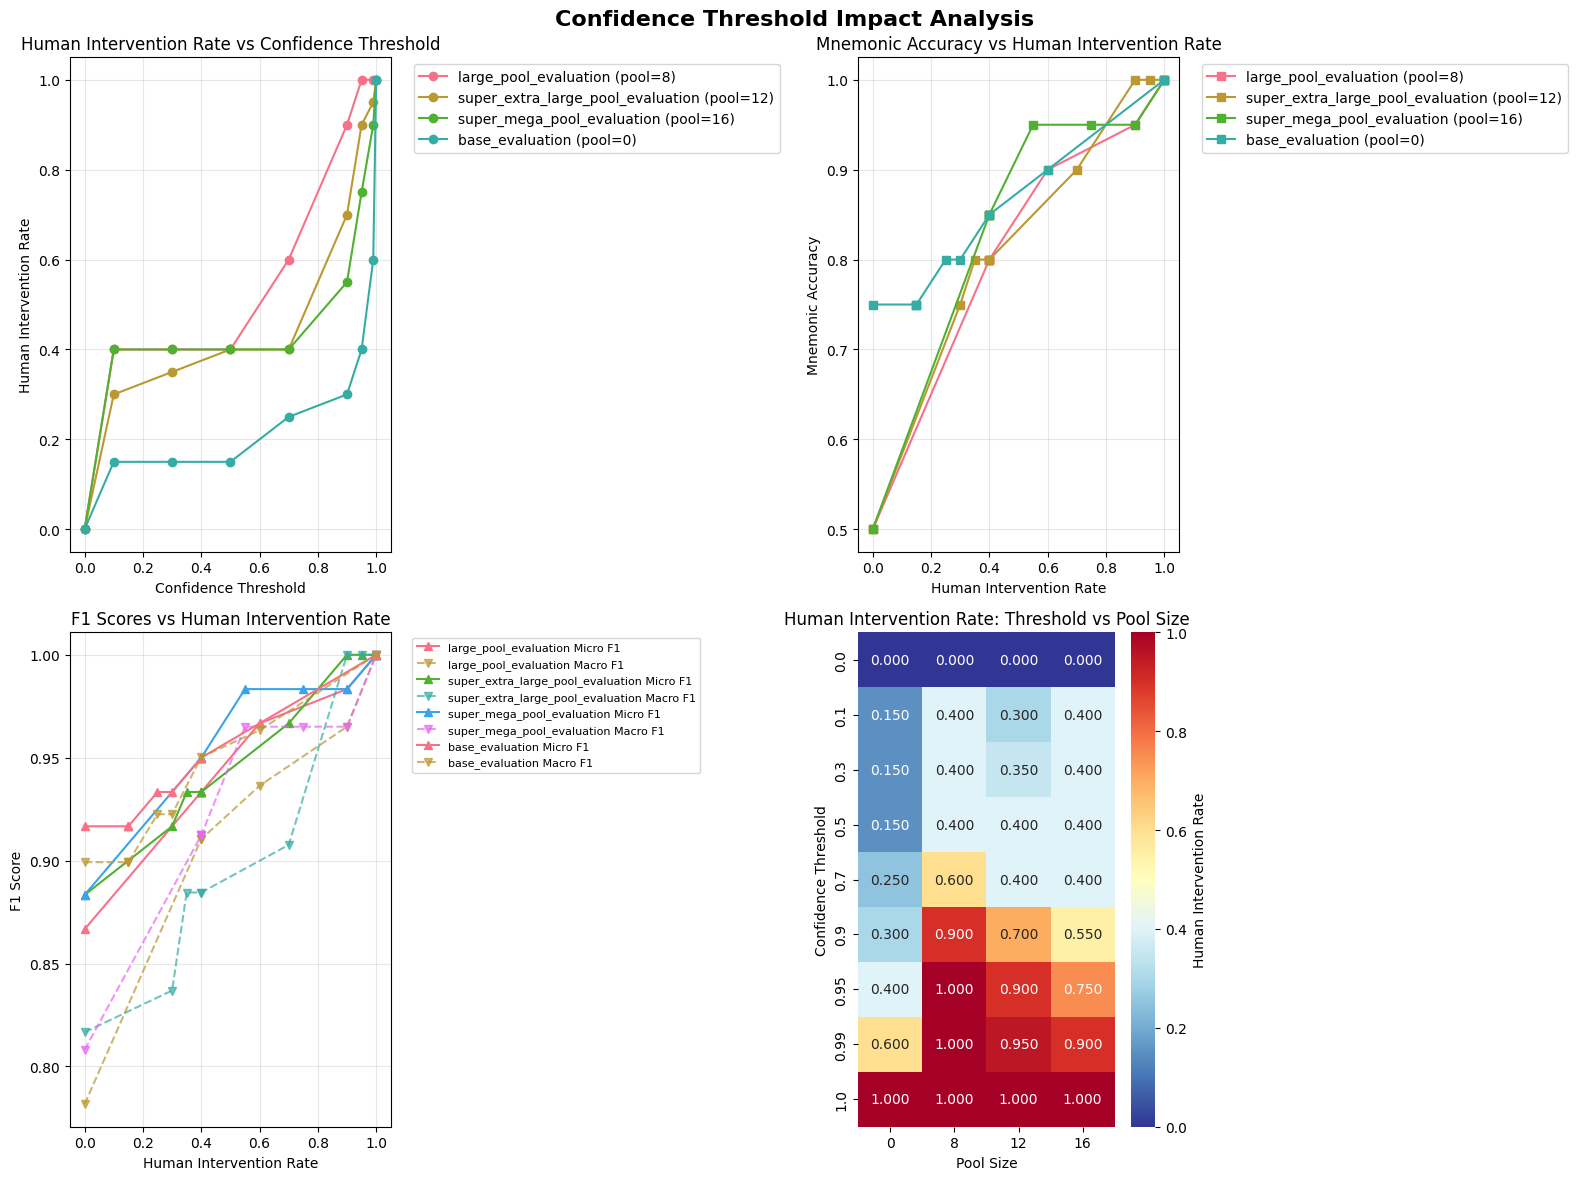


THRESHOLD ANALYSIS SUMMARY

Configurations analyzed: 4
Thresholds tested: [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]

LARGE_POOL_EVALUATION:
  Pool size: 8
  Optimal threshold: 0.0 (accuracy=0.500, intervention=0.000)
  Range: intervention_rate [0.000-1.000]
         accuracy [0.500-1.000]

SUPER_EXTRA_LARGE_POOL_EVALUATION:
  Pool size: 12
  Optimal threshold: 0.0 (accuracy=0.500, intervention=0.000)
  Range: intervention_rate [0.000-1.000]
         accuracy [0.500-1.000]

SUPER_MEGA_POOL_EVALUATION:
  Pool size: 16
  Optimal threshold: 0.0 (accuracy=0.500, intervention=0.000)
  Range: intervention_rate [0.000-1.000]
         accuracy [0.500-1.000]

BASE_EVALUATION:
  Pool size: 0
  Optimal threshold: 0.0 (accuracy=0.750, intervention=0.000)
  Range: intervention_rate [0.000-1.000]
         accuracy [0.750-1.000]

💾 Results saved to: c:\Users\qwert\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\threshold_analysis_20250819_193820.json
🎯 Analysis c

In [7]:
## 3. Visualize and Save Threshold Analysis Results

def save_threshold_analysis_results(all_results: Dict[str, Dict], output_path: str) -> None:
    """Save threshold analysis results in a structured format."""
    
    # Prepare structured output
    structured_results = {
        "analysis_metadata": {
            "timestamp": datetime.now().isoformat(),
            "thresholds_tested": THRESHOLD_GRID["thresholds"],
            "configurations_analyzed": list(all_results.keys()),
            "analysis_type": "threshold_sensitivity"
        },
        "results_by_configuration": {}
    }
    
    for config_name, threshold_results in all_results.items():
        config_data = {
            "original_config": RECOGNITION_CONFIGS[config_name],
            "threshold_analysis": {}
        }
        
        for threshold, analysis in threshold_results.items():
            metrics = analysis["metrics"]
            
            config_data["threshold_analysis"][str(threshold)] = {
                "threshold": threshold,
                "human_intervention_rate": metrics["human_intervention_metrics"]["rate"],
                "mnemonic_accuracy": metrics["mnemonic_metrics"]["accuracy"],
                "micro_f1": metrics["micro_metrics"]["f1"],
                "micro_precision": metrics["micro_metrics"]["precision"],
                "micro_recall": metrics["micro_metrics"]["recall"],
                "macro_f1": metrics["macro_metrics"]["f1"],
                "macro_precision": metrics["macro_metrics"]["precision"],
                "macro_recall": metrics["macro_metrics"]["recall"],
                "total_interventions": metrics["human_intervention_metrics"]["total_interventions"],
                "total_samples": metrics["total_samples"],
                "per_class_f1": {
                    class_type: metrics["per_class_metrics"][class_type]["f1_micro"]
                    for class_type in ["PrototypeData", "Quantity", "Unit"]
                }
            }
        
        structured_results["results_by_configuration"][config_name] = config_data
    
    # Save to file
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(structured_results, f, indent=2, ensure_ascii=False)
    
    print(f"Threshold analysis results saved to: {output_path}")

# Create comprehensive visualizations
def create_threshold_visualizations(all_results: Dict[str, Dict]):
    """Create visualizations showing the impact of confidence thresholds."""
    
    # Prepare data for plotting
    plot_data = []
    
    for config_name, threshold_results in all_results.items():
        for threshold, analysis in threshold_results.items():
            metrics = analysis["metrics"]
            
            plot_data.append({
                "Configuration": config_name,
                "Threshold": threshold,
                "Human_Intervention_Rate": metrics["human_intervention_metrics"]["rate"],
                "Mnemonic_Accuracy": metrics["mnemonic_metrics"]["accuracy"],
                "Micro_F1": metrics["micro_metrics"]["f1"],
                "Macro_F1": metrics["macro_metrics"]["f1"],
                "Pool_Size": RECOGNITION_CONFIGS[config_name].get("pool_size", 0),
                "Advance_Ratio": RECOGNITION_CONFIGS[config_name].get("advance_ratio", 0)
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Confidence Threshold Impact Analysis', fontsize=16, fontweight='bold')
    
    # 1. Human Intervention Rate vs Threshold
    for config in df['Configuration'].unique():
        config_data = df[df['Configuration'] == config]
        axes[0,0].plot(config_data['Threshold'], config_data['Human_Intervention_Rate'], 
                      marker='o', label=f"{config} (pool={config_data['Pool_Size'].iloc[0]})")
    
    axes[0,0].set_xlabel('Confidence Threshold')
    axes[0,0].set_ylabel('Human Intervention Rate')
    axes[0,0].set_title('Human Intervention Rate vs Confidence Threshold')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Mnemonic Accuracy vs Threshold
    for config in df['Configuration'].unique():
        config_data = df[df['Configuration'] == config]
        axes[0,1].plot(config_data['Human_Intervention_Rate'], config_data['Mnemonic_Accuracy'], 
                      marker='s', label=f"{config} (pool={config_data['Pool_Size'].iloc[0]})")

    axes[0,1].set_xlabel('Human Intervention Rate')
    axes[0,1].set_ylabel('Mnemonic Accuracy')
    axes[0,1].set_title('Mnemonic Accuracy vs Human Intervention Rate')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. F1 Scores vs Threshold
    for config in df['Configuration'].unique():
        config_data = df[df['Configuration'] == config]
        axes[1,0].plot(config_data['Human_Intervention_Rate'], config_data['Micro_F1'], 
                      marker='^', label=f"{config} Micro F1")
        axes[1,0].plot(config_data['Human_Intervention_Rate'], config_data['Macro_F1'], 
                      marker='v', linestyle='--', alpha=0.7, label=f"{config} Macro F1")

    axes[1,0].set_xlabel('Human Intervention Rate')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 Scores vs Human Intervention Rate')
    axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Threshold vs Pool Size Heatmap (Human Intervention Rate)
    pivot_data = df.pivot_table(values='Human_Intervention_Rate', 
                               index='Threshold', 
                               columns='Pool_Size', 
                               aggfunc='mean')
    
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=axes[1,1], cbar_kws={'label': 'Human Intervention Rate'})
    axes[1,1].set_title('Human Intervention Rate: Threshold vs Pool Size')
    axes[1,1].set_xlabel('Pool Size')
    axes[1,1].set_ylabel('Confidence Threshold')
    
    plt.tight_layout()
    plt.show()
    
    return df

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_file = RESULTS_DIR / f"threshold_analysis_{timestamp}.json"

save_threshold_analysis_results(all_threshold_results, str(results_file))

# Create visualizations
print("Creating threshold analysis visualizations...")
threshold_df = create_threshold_visualizations(all_threshold_results)

# Display summary statistics
print("\n" + "="*80)
print("THRESHOLD ANALYSIS SUMMARY")
print("="*80)

print(f"\nConfigurations analyzed: {len(all_threshold_results)}")
print(f"Thresholds tested: {THRESHOLD_GRID['thresholds']}")

# Show key insights
for config_name, threshold_results in all_threshold_results.items():
    print(f"\n{config_name.upper()}:")
    config_summary = []
    
    for threshold, analysis in threshold_results.items():
        metrics = analysis["metrics"]
        config_summary.append({
            "threshold": threshold,
            "intervention_rate": metrics["human_intervention_metrics"]["rate"],
            "accuracy": metrics["mnemonic_metrics"]["accuracy"],
            "f1": metrics["micro_metrics"]["f1"]
        })
    
    # Find optimal threshold (balance between low intervention and high accuracy)
    config_summary.sort(key=lambda x: x["accuracy"] - x["intervention_rate"], reverse=True)
    optimal = config_summary[0]

    print(f"  Pool size: {RECOGNITION_CONFIGS[config_name].get('pool_size', 0)}")
    print(f"  Optimal threshold: {optimal['threshold']} (accuracy={optimal['accuracy']:.3f}, intervention={optimal['intervention_rate']:.3f})")
    print(f"  Range: intervention_rate [{min(s['intervention_rate'] for s in config_summary):.3f}-{max(s['intervention_rate'] for s in config_summary):.3f}]")
    print(f"         accuracy [{min(s['accuracy'] for s in config_summary):.3f}-{max(s['accuracy'] for s in config_summary):.3f}]")

print(f"\n💾 Results saved to: {results_file}")
print("🎯 Analysis complete! Judge confidence threshold importance assessed.")

In [8]:
# Define validation rounds grid for testing
VALIDATION_ROUNDS = [
    1, 2, 3,
]

In [ ]:
# Import validation modules and initialize task manager
import sys
sys.path.append(str(project_root / "server"))

from utils.recognition.judge import judge_recognition_quality, assess_human_intervention_needed
from utils import task_manager
from utils.config import globals_config

# Initialize the task manager with all required resources
print("Initializing task manager resources...")
try:
    globals_config.load_files()
    print("✓ Task manager initialized successfully")
    print(f"✓ Loaded prompt templates: {list(task_manager.prompt_template_collection.keys())}")
    print(f"✓ Loaded complementary knowledge keys: {list(task_manager.complementary_knowledge.keys())}")
except Exception as e:
    print(f"✗ Failed to initialize task manager: {e}")
    # Create minimal fallbacks
    task_manager.prompt_template_collection = {"Generic": {}}
    task_manager.complementary_knowledge = {"basic": "No specific drilling terminology knowledge provided."}

def simulate_validation_with_rounds(
    cache_data: Dict[str, Any], 
    validation_rounds: int,
    threshold: float = 0.5
) -> List[Dict[str, Any]]:
    """
    Simulate validation with different rounds using cached recognition data.
    
    Args:
        cache_data: Recognition cache data
        validation_rounds: Number of validation rounds to simulate
        threshold: Confidence threshold for human intervention
        
    Returns:
        List of evaluation results with simulated validation
    """
    evaluation_results = []
    recognition_cache = cache_data.get("recognition_cache", {})
    
    for mnemonic, cache_entry in recognition_cache.items():
        recognition_result = cache_entry.get("recognition_result", {})
        
        # Extract components from cache
        recognized_class = recognition_result.get("recognized_class", {})
        candidates = recognition_result.get("candidates", {})
        meta_info = recognition_result.get("meta_info", {})
        ground_truth_label = cache_entry.get("label", {})
        
        # Get original sample data
        original_sample = cache_entry.get("sample", {})
        original_mnemonic = original_sample.get("mnemonic", mnemonic)
        
        # Create user_query from sample data (this is what task_manager expects)
        user_query_dict = {
            "mnemonic": original_mnemonic,
            "description": original_sample.get("description", ""),
            "unit": original_sample.get("unit", "")
        }
        user_query = json.dumps(user_query_dict)
        
        # Simulate validation with specified rounds
        try:
            # Use judge_recognition_quality with proper parameters
            validation_confidence, validation_info = judge_recognition_quality(
                mnemonic=user_query,  # This expects the full metadata as JSON string
                recognized_class=recognized_class,
                candidates=candidates,  # This is the dict with probabilities
                interpretation=None,  # We don't have interpretation in cache
                prompt_templates=task_manager.prompt_template_collection.get("Generic", {}),
                model="gpt-4o-mini",  # Use same model as original
                rounds=validation_rounds,
                user_config=None,
                complementary_knowledge=task_manager.complementary_knowledge
            )
            
        except Exception as e:
            print(f"Warning: Validation failed for {mnemonic}: {e}")
            # Fallback to original confidence
            validation_confidence = meta_info.get("judge_score", 0.0)
            validation_info = {"error": str(e)}
        
        # Assess human intervention with validation confidence
        additional_criteria = {"total_candidates": sum(len(v) if isinstance(v, dict) else 0 for v in candidates.values())}
        human_intervention_needed, reason = assess_human_intervention_needed(
            recognized_class=recognized_class,
            candidates=candidates,
            confidence_score=validation_confidence,
            threshold=threshold,
            additional_criteria=additional_criteria
        )
        
        # Convert candidates format for evaluation (from prob dict to sorted list)
        candidates_list_format = {}
        for key, candidate_dict in candidates.items():
            if isinstance(candidate_dict, dict):
                sorted_candidates = sorted(candidate_dict.items(), key=lambda x: x[1], reverse=True)
                candidates_list_format[key] = [item for item, prob in sorted_candidates]
            else:
                candidates_list_format[key] = candidate_dict
        
        # Use evaluate_single_prediction to get proper evaluation result
        eval_result = evaluate_single_prediction(
            prediction=recognized_class,
            candidates=candidates_list_format,
            human_intervention=human_intervention_needed,
            label=ground_truth_label,
            mnemonic=mnemonic
        )
        
        # Add validation metadata
        eval_result["validation_rounds"] = validation_rounds
        eval_result["validation_confidence"] = validation_confidence
        eval_result["original_confidence"] = meta_info.get("judge_score", 0.0)
        eval_result["human_intervention_reason"] = reason
        eval_result["threshold_used"] = threshold
        eval_result["validation_info"] = validation_info
        
        evaluation_results.append(eval_result)
    
    return evaluation_results

def analyze_cache_under_validation_rounds(
    cache_file_path: str, 
    validation_rounds_list: List[int],
    threshold: float = 0.5
) -> Dict[int, Dict[str, Any]]:
    """
    Analyze recognition cache results under different validation rounds.
    
    Args:
        cache_file_path: Path to recognition cache file
        validation_rounds_list: List of validation round counts to test
        threshold: Confidence threshold for human intervention
        
    Returns:
        Dictionary with metrics for each validation round count
    """
    # Load cache data
    with open(cache_file_path) as f:
        cache_data = json.load(f)
    
    print(f"Analyzing {len(cache_data.get('recognition_cache', {}))} results under {len(validation_rounds_list)} validation round configurations...")
    
    validation_analysis = {}
    
    for rounds in validation_rounds_list:
        print(f"\nProcessing validation rounds: {rounds}")
        
        # Simulate validation with specified rounds
        evaluation_results = simulate_validation_with_rounds(cache_data, rounds, threshold)
        
        # Calculate metrics using the same function as the main pipeline
        metrics = calculate_comprehensive_metrics(evaluation_results)
        
        # Store results
        validation_analysis[rounds] = {
            "metrics": metrics,
            "evaluation_results": evaluation_results
        }
        
        # Print summary with safe access to metrics
        hi_metrics = metrics.get('human_intervention_metrics', {})
        mnemonic_metrics = metrics.get('mnemonic_metrics', {})
        micro_metrics = metrics.get('micro_metrics', {})
        
        print(f"  Human intervention rate: {hi_metrics.get('rate', 0.0):.3f}")
        print(f"  Mnemonic accuracy: {mnemonic_metrics.get('accuracy', 0.0):.3f}")
        print(f"  Micro F1: {micro_metrics.get('f1', 0.0):.3f}")
        print(f"  Micro Precision: {micro_metrics.get('precision', 0.0):.3f}")
        print(f"  Micro Recall: {micro_metrics.get('recall', 0.0):.3f}")
        print(f"  Total interventions: {hi_metrics.get('total_interventions', 0)}")
    
    return validation_analysis

def create_validation_rounds_visualizations(all_results: Dict[str, Dict]):
    """Create visualizations showing the impact of validation rounds."""
    
    # Prepare data for plotting
    plot_data = []
    
    for config_name, rounds_results in all_results.items():
        for rounds, analysis in rounds_results.items():
            metrics = analysis["metrics"]
            
            plot_data.append({
                "Configuration": config_name,
                "Validation_Rounds": rounds,
                "Human_Intervention_Rate": metrics["human_intervention_metrics"]["rate"],
                "Mnemonic_Accuracy": metrics["mnemonic_metrics"]["accuracy"],
                "Micro_F1": metrics["micro_metrics"]["f1"],
                "Macro_F1": metrics["macro_metrics"]["f1"],
                "Pool_Size": RECOGNITION_CONFIGS[config_name]["pool_size"],
                "Advance_Ratio": RECOGNITION_CONFIGS[config_name]["advance_ratio"]
            })
    
    df = pd.DataFrame(plot_data)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Validation Rounds Impact Analysis', fontsize=16, fontweight='bold')
    
    # 1. Human Intervention Rate vs Validation Rounds
    for config in df['Configuration'].unique():
        config_data = df[df['Configuration'] == config]
        axes[0,0].plot(config_data['Validation_Rounds'], config_data['Human_Intervention_Rate'], 
                      marker='o', label=f"{config} (pool={config_data['Pool_Size'].iloc[0]})")
    
    axes[0,0].set_xlabel('Validation Rounds')
    axes[0,0].set_ylabel('Human Intervention Rate')
    axes[0,0].set_title('Human Intervention Rate vs Validation Rounds')
    axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Mnemonic Accuracy vs Validation Rounds
    for config in df['Configuration'].unique():
        config_data = df[df['Configuration'] == config]
        axes[0,1].plot(config_data['Validation_Rounds'], config_data['Mnemonic_Accuracy'], 
                      marker='s', label=f"{config} (pool={config_data['Pool_Size'].iloc[0]})")
    
    axes[0,1].set_xlabel('Validation Rounds')
    axes[0,1].set_ylabel('Mnemonic Accuracy')
    axes[0,1].set_title('Mnemonic Accuracy vs Validation Rounds')
    axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. F1 Scores vs Validation Rounds
    for config in df['Configuration'].unique():
        config_data = df[df['Configuration'] == config]
        axes[1,0].plot(config_data['Validation_Rounds'], config_data['Micro_F1'], 
                      marker='^', label=f"{config} Micro F1")
        axes[1,0].plot(config_data['Validation_Rounds'], config_data['Macro_F1'], 
                      marker='v', linestyle='--', alpha=0.7, label=f"{config} Macro F1")
    
    axes[1,0].set_xlabel('Validation Rounds')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 Scores vs Validation Rounds')
    axes[1,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Validation Rounds vs Pool Size Heatmap (Human Intervention Rate)
    pivot_data = df.pivot_table(values='Human_Intervention_Rate', 
                               index='Validation_Rounds', 
                               columns='Pool_Size', 
                               aggfunc='mean')
    
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=axes[1,1], cbar_kws={'label': 'Human Intervention Rate'})
    axes[1,1].set_title('Human Intervention Rate: Validation Rounds vs Pool Size')
    axes[1,1].set_xlabel('Pool Size')
    axes[1,1].set_ylabel('Validation Rounds')
    
    plt.tight_layout()
    plt.show()
    
    return df

def save_validation_analysis_results(all_results: Dict[str, Dict], output_path: str) -> None:
    """Save validation rounds analysis results in a structured format."""
    
    # Prepare structured output
    structured_results = {
        "analysis_metadata": {
            "timestamp": datetime.now().isoformat(),
            "validation_rounds_tested": VALIDATION_ROUNDS,
            "configurations_analyzed": list(all_results.keys()),
            "analysis_type": "validation_rounds_sensitivity"
        },
        "results_by_configuration": {}
    }
    
    for config_name, rounds_results in all_results.items():
        config_data = {
            "original_config": RECOGNITION_CONFIGS[config_name],
            "validation_rounds_analysis": {}
        }
        
        for rounds, analysis in rounds_results.items():
            metrics = analysis["metrics"]
            
            config_data["validation_rounds_analysis"][str(rounds)] = {
                "validation_rounds": rounds,
                "human_intervention_rate": metrics["human_intervention_metrics"]["rate"],
                "mnemonic_accuracy": metrics["mnemonic_metrics"]["accuracy"],
                "micro_f1": metrics["micro_metrics"]["f1"],
                "micro_precision": metrics["micro_metrics"]["precision"],
                "micro_recall": metrics["micro_metrics"]["recall"],
                "macro_f1": metrics["macro_metrics"]["f1"],
                "macro_precision": metrics["macro_metrics"]["precision"],
                "macro_recall": metrics["macro_metrics"]["recall"],
                "total_interventions": metrics["human_intervention_metrics"]["total_interventions"],
                "total_samples": metrics["total_samples"],
                "per_class_f1": {
                    class_type: metrics["per_class_metrics"][class_type]["f1_micro"]
                    for class_type in ["PrototypeData", "Quantity", "Unit"]
                }
            }
        
        structured_results["results_by_configuration"][config_name] = config_data
    
    # Save to file
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(structured_results, f, indent=2, ensure_ascii=False)
    
    print(f"Validation rounds analysis results saved to: {output_path}")

print("✓ Validation rounds analysis functions defined")
print("Available functions:")
print("  - simulate_validation_with_rounds(): Simulate validation with specific rounds")
print("  - analyze_cache_under_validation_rounds(): Analyze cache under different round counts")
print("  - create_validation_rounds_visualizations(): Create impact visualizations")
print("  - save_validation_analysis_results(): Save structured results")

2025-08-14 14:30:39,898 - utils.task_manager - INFO - Start retrieving knowledge.


Initializing task manager resources...


2025-08-14 14:30:41,122 - utils.task_manager - INFO - Finish retrieving knowledge.


✓ Task manager initialized successfully
✓ Loaded prompt templates: ['Generic', 'PC', 'PC_CoT']
✓ Loaded complementary knowledge keys: ['basic']
✓ Validation rounds analysis functions defined
Available functions:
  - simulate_validation_with_rounds(): Simulate validation with specific rounds
  - analyze_cache_under_validation_rounds(): Analyze cache under different round counts
  - create_validation_rounds_visualizations(): Create impact visualizations
  - save_validation_analysis_results(): Save structured results


In [10]:
# Run Validation Rounds Analysis on Available Caches

print("Starting validation rounds analysis...")
print(f"Testing validation rounds: {VALIDATION_ROUNDS}")

# Analyze each recognition cache under different validation rounds
all_validation_results = {}

for cache_name, config in RECOGNITION_CONFIGS.items():
    cache_file = CACHE_DIR / f"{cache_name}.json"
    if not cache_file.exists():
        print(f"Cache file {cache_file} does not exist, skipping {cache_name}")
        continue

    print(f"\n{'='*60}")
    print(f"ANALYZING VALIDATION ROUNDS: {cache_name}")
    print(f"{'='*60}")
    print(f"Loading cache from: {cache_file}")

    # Analyze under different validation rounds (using threshold 0.5)
    validation_results = analyze_cache_under_validation_rounds(
        str(cache_file), 
        VALIDATION_ROUNDS,
        threshold=0.5  # Use standard threshold
    )
    
    all_validation_results[cache_name] = validation_results
    
    print(f"\n✓ Completed validation rounds analysis for {cache_name}")

print(f"\n🎉 Completed validation rounds analysis for {len(all_validation_results)} cache configurations")

Starting validation rounds analysis...
Testing validation rounds: [1, 2, 3]

ANALYZING VALIDATION ROUNDS: large_pool_evaluation
Loading cache from: c:\Users\michu0018\Documents\Git\ddbot-chat\data_store\test_data\recognition_cache\large_pool_evaluation.json
Analyzing 20 results under 3 validation round configurations...

Processing validation rounds: 1
  Human intervention rate: 0.500
  Mnemonic accuracy: 0.950
  Micro F1: 0.983
  Micro Precision: 0.983
  Micro Recall: 0.983
  Total interventions: 10

Processing validation rounds: 2
  Human intervention rate: 0.500
  Mnemonic accuracy: 0.850
  Micro F1: 0.950
  Micro Precision: 0.950
  Micro Recall: 0.950
  Total interventions: 10

Processing validation rounds: 3
  Human intervention rate: 0.500
  Mnemonic accuracy: 0.900
  Micro F1: 0.967
  Micro Precision: 0.967
  Micro Recall: 0.967
  Total interventions: 10

✓ Completed validation rounds analysis for large_pool_evaluation

ANALYZING VALIDATION ROUNDS: super_extra_large_pool_evaluat

Validation rounds analysis results saved to: c:\Users\michu0018\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\validation_rounds_analysis_20250814_154805.json
Creating validation rounds analysis visualizations...


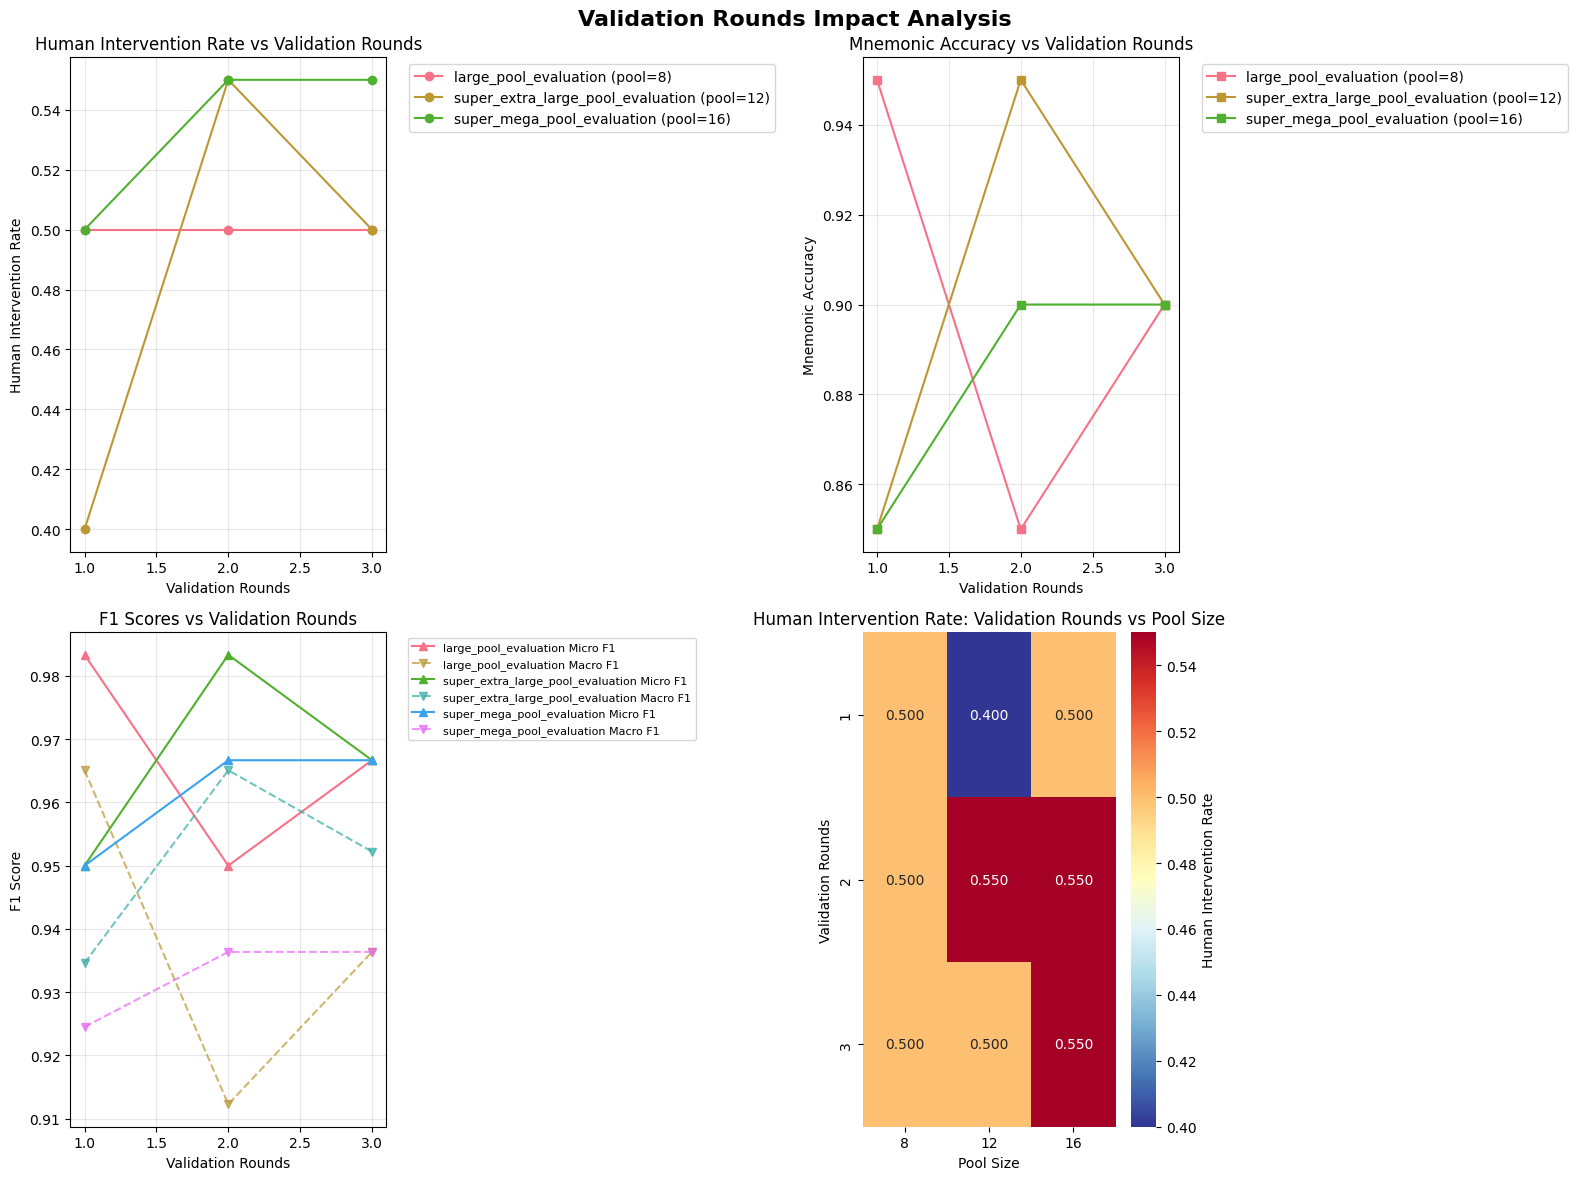


VALIDATION ROUNDS ANALYSIS SUMMARY

Configurations analyzed: 3
Validation rounds tested: [1, 2, 3]

LARGE_POOL_EVALUATION:
  Pool size: 8
  Optimal rounds: 1 (accuracy=0.950, intervention=0.500)
  Range: intervention_rate [0.500-0.500]
         accuracy [0.850-0.950]
  Trend: accuracy ↘ (-0.0250), intervention → (+0.0000)

SUPER_EXTRA_LARGE_POOL_EVALUATION:
  Pool size: 12
  Optimal rounds: 1 (accuracy=0.850, intervention=0.400)
  Range: intervention_rate [0.400-0.550]
         accuracy [0.850-0.950]
  Trend: accuracy ↗ (+0.0250), intervention ↗ (+0.0500)

SUPER_MEGA_POOL_EVALUATION:
  Pool size: 16
  Optimal rounds: 1 (accuracy=0.850, intervention=0.500)
  Range: intervention_rate [0.500-0.550]
         accuracy [0.850-0.900]
  Trend: accuracy ↗ (+0.0250), intervention ↗ (+0.0250)

💾 Results saved to: c:\Users\michu0018\Documents\Git\ddbot-chat\data_store\test_data\Annotated data\evaluation_results\validation_rounds_analysis_20250814_154805.json
🎯 Analysis complete! Validation rounds

,Config,Pool,Rounds,Accuracy,Intervention,Micro_F1,Efficiency
0,large_pool,8,1,0.95,0.50,0.983333,0.45
1,large_pool,8,2,0.85,0.50,0.950000,0.35
2,large_pool,8,3,0.90,0.50,0.966667,0.40
3,super_extra_large_pool,12,1,0.85,0.40,0.950000,0.45
4,super_extra_large_pool,12,2,0.95,0.55,0.983333,0.40
5,super_extra_large_pool,12,3,0.90,0.50,0.966667,0.40
6,super_mega_pool,16,1,0.85,0.50,0.950000,0.35
7,super_mega_pool,16,2,0.90,0.55,0.966667,0.35
8,super_mega_pool,16,3,0.90,0.55,0.966667,0.35


In [11]:
# Visualize and Save Validation Rounds Analysis Results

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
validation_results_file = RESULTS_DIR / f"validation_rounds_analysis_{timestamp}.json"

save_validation_analysis_results(all_validation_results, str(validation_results_file))

# Create visualizations
print("Creating validation rounds analysis visualizations...")
validation_df = create_validation_rounds_visualizations(all_validation_results)

# Display summary statistics
print("\n" + "="*80)
print("VALIDATION ROUNDS ANALYSIS SUMMARY")
print("="*80)

print(f"\nConfigurations analyzed: {len(all_validation_results)}")
print(f"Validation rounds tested: {VALIDATION_ROUNDS}")

# Show key insights
for config_name, rounds_results in all_validation_results.items():
    print(f"\n{config_name.upper()}:")
    config_summary = []
    
    for rounds, analysis in rounds_results.items():
        metrics = analysis["metrics"]
        config_summary.append({
            "rounds": rounds,
            "intervention_rate": metrics["human_intervention_metrics"]["rate"],
            "accuracy": metrics["mnemonic_metrics"]["accuracy"],
            "f1": metrics["micro_metrics"]["f1"]
        })
    
    # Find optimal validation rounds (balance between low intervention and high accuracy)
    config_summary.sort(key=lambda x: x["accuracy"] - x["intervention_rate"], reverse=True)
    optimal = config_summary[0]
    
    print(f"  Pool size: {RECOGNITION_CONFIGS[config_name]['pool_size']}")
    print(f"  Optimal rounds: {optimal['rounds']} (accuracy={optimal['accuracy']:.3f}, intervention={optimal['intervention_rate']:.3f})")
    print(f"  Range: intervention_rate [{min(s['intervention_rate'] for s in config_summary):.3f}-{max(s['intervention_rate'] for s in config_summary):.3f}]")
    print(f"         accuracy [{min(s['accuracy'] for s in config_summary):.3f}-{max(s['accuracy'] for s in config_summary):.3f}]")
    
    # Show trend analysis
    # Sort by rounds to see trend
    config_summary.sort(key=lambda x: x["rounds"])
    accuracy_trend = [s["accuracy"] for s in config_summary]
    intervention_trend = [s["intervention_rate"] for s in config_summary]
    
    # Calculate trend direction (positive = improving, negative = deteriorating)
    if len(accuracy_trend) > 2:
        accuracy_slope = (accuracy_trend[-1] - accuracy_trend[0]) / (len(accuracy_trend) - 1)
        intervention_slope = (intervention_trend[-1] - intervention_trend[0]) / (len(intervention_trend) - 1)
        
        print(f"  Trend: accuracy {'↗' if accuracy_slope > 0.001 else '↘' if accuracy_slope < -0.001 else '→'} "
              f"({accuracy_slope:+.4f}), intervention {'↗' if intervention_slope > 0.001 else '↘' if intervention_slope < -0.001 else '→'} "
              f"({intervention_slope:+.4f})")

print(f"\n💾 Results saved to: {validation_results_file}")
print("🎯 Analysis complete! Validation rounds effectiveness assessed.")

# Create summary comparison table
print("\n" + "="*80)
print("VALIDATION ROUNDS EFFECTIVENESS COMPARISON")
print("="*80)

comparison_data = []
for config_name, rounds_results in all_validation_results.items():
    pool_size = RECOGNITION_CONFIGS[config_name]['pool_size']
    
    for rounds, analysis in rounds_results.items():
        metrics = analysis["metrics"]
        comparison_data.append({
            "Config": config_name.replace("_evaluation", ""),
            "Pool": pool_size,
            "Rounds": rounds,
            "Accuracy": metrics["mnemonic_metrics"]["accuracy"],
            "Intervention": metrics["human_intervention_metrics"]["rate"],
            "Micro_F1": metrics["micro_metrics"]["f1"],
            "Efficiency": metrics["mnemonic_metrics"]["accuracy"] - metrics["human_intervention_metrics"]["rate"]
        })

comparison_df = pd.DataFrame(comparison_data)

# Show top performing configurations
print("\nTop 10 Most Efficient Configurations (Accuracy - Intervention Rate):")
top_configs = comparison_df.nlargest(10, 'Efficiency')
print(top_configs[['Config', 'Pool', 'Rounds', 'Accuracy', 'Intervention', 'Efficiency']].to_string(index=False))

# Show validation rounds effectiveness by pool size
print("\nValidation Rounds Effectiveness by Pool Size:")
for pool_size in sorted(comparison_df['Pool'].unique()):
    pool_data = comparison_df[comparison_df['Pool'] == pool_size]
    best_config = pool_data.loc[pool_data['Efficiency'].idxmax()]
    print(f"  Pool {pool_size}: Best at {best_config['Rounds']} rounds "
          f"(Accuracy: {best_config['Accuracy']:.3f}, Intervention: {best_config['Intervention']:.3f})")

display(comparison_df.head(20))